# Modelo SIR: Uma abordagem estocástica e determinística

- PET - Física
- Petianos: Ylana Karolina Santos Lopes
- Data: 18 de Abril de 2025

$\quad$ O presente `Notebook` tem como objetivo o estudo do modelo SIR, um modelo matemático simples usado em epidemologia para descrever a propagação de doenças infeciosas. Adotaremos uma abordagem comparativa, analisando o comportamento modelo na sua forma determinísca e estocástica. Dessa forma, este trabalho introduzirá conceitos chave de epidemologia e propagação de doenças, como também discutirá o algoritmo de Gillespie que foi implementado para a abordagem estocástica. Este `Notebook` será organizado da seguinte forma:

1. *Introdução;*
2. *Abordagem Determinística;*
3. *Abordagem Estocástica;*
4. *Comparação;*
5. *Conclusão;*
6. *Bônus: Visualização da propagação de doença.*

## Nota de Agradecimento

---

O conteúdo desse `Notebook` foi inspirado no trabalho realizado na Escola de Verão ICTP-SAIFR para Jovens Físicos no início de 2023, superviosionado por Andrés Guzmán que idealizou o projeto e nos guiou durante o evento. Por mais que não tenha continuado nesse campo, 2 anos depois ainda rende frutos - além de ter me feito enxergar a física com novos olhos. Então deixo aqui os meus agradecimentos a Andrés, Matheus, Isabella e Felipi.

---

## Importando bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import odeint


## Detalhes das bibliotecas

In [3]:
%load_ext version_information
%version_information matplotlib, numpy, scipy

Software versions
Python 3.11.8 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.20.0
OS Windows 10 10.0.22631 SP0
matplotlib 3.8.0
numpy 1.26.4
scipy 1.12.0
Sun Apr 13 09:01:11 2025 Hora oficial do Brasil

In [4]:
""" Só uma função para formatar as figuras, e deixar o o código menos poluído. """
def format():
    plt.tick_params(direction='in', which = 'both', bottom = 1, top =1, left = 1, right = 1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(frameon = False)

## 1. Introdução
$\quad$ Uma doença é dita infecciosa quando o agente causador (virus, bactéria, protozoário ou toxina) pode ser transmitido de um indivíduo (hospedeiro) para outro por meio de modos de transmissão como o toque, gotículas no ar, ou até de mãe para filho. Ao infectar parcela considerável da população em um intervalo curto de tempo, a doença é dita uma epidemia [1]. E ao se espalhar por todo o globo, se transforma numa pandemia - o que é cada vez mais fácil com o crescimento do fluxo aéreo de passageiros. Assim, modelagem matemática pode prover um entendimento do mecanismo de disseminação das doenças, ajudando a definir pontos importantes no processo de transmissão e consequentemente como por em prática medidas preventivas.

$\quad$ Geralmente, epidemias não são a primeira coisa que vem a mente quando se pensa em física e matemática. Porém, a característica da física de descrever processos naturais usando de artifícios matemáticos se enquandra perfeitamente no contexto deste `Notebook`. A modelagem matemática dentro da epidemologia adota uma posição importante, criando modelos que que auxiliam na tomada de decisões em épocas de crise pública - como em 2020, com o Covid-19. Com isso, é possível prever a evolução de uma doença otimizando a distribuição de recursos para combater seu avanço. Aqui trataremos do modelo SIR que divide a população em três grupos: Suscetível (S); Infectados (I); e Recuperados (R) [2]. Apesar da sua simplicidade, esse modelo é capaz de descrever os processos de transmissão da doença, e consequente transição de um grupo ao outro.

## 2. Abordagem determinística
### 2.1 Modelo SIR

$\quad$ Nós vamos considerar uma epidemia evoluindo em uma população de tamanho N constante. Para fins de entendimento, vamos pensar nesse modelo na sua forma determinística nessa seção. A estrutura do modelo SIR está disposta aqui na sua versão mais básica. Como citado na introdução, nesse modelo a população é divididade em três grupos:

- (**S**) o grupo dos suscetíveis: os indivíduos "saudáveis" que são capazes de contrair a doença e se tornarem infectados;
- (**I**) o grupo dos infectados: aqueles indivíduos que foram infectados, e são capazes de transmitir a doença para os suscetíveis;
- (**R**) o grupo dos recuperados: os indivíduos que contraíram a doença e se tornam permanentemente imunes, ou morreram - não sendo capazes de continuar a transmitir a doença.

$\quad$ No nosso caso, não estamos considerando a dinâmica de vitalidade que descreve as taxas de nascimento e mortalidade natural. Essa adição seria importante para doenças que permanecem em uma população por décadas, de forma que o número de pessoas que nascem e morrem se torna relevante. O tipo de epidemias que modelamos nesse `Notebook` se aproxima mais da influenza, rubeola ou do próprio Covid-19. Ou seja, acontecem relativamente rápidas o que nos leva a desprezar a dinâmica de vitalidade, assumindo que o número de mortes e de nascimentos se anulam. Assim, podemos considerar a população $N$ como constante de acordo com a expressão abaixo.

$$N = S + I + R $$.

$\quad$ Com isso, para descrever a dinâmica com que nossa epidemia hipotética evolui precisamos de equações diferenciais. Aqui usamos o conjunto de três equações - uma para descrever as taxas de transferência de um compartimento para outro, tudo em função do tempo.

$$
\begin{align}
\frac{dS}{dt} &= - \beta S I. \tag{1} \\
\frac{dI}{dt} &= \beta S I - \mu I. \tag{2}\\
\frac{dR}{dt} &= \mu I. \tag{3}\\
\end{align}
$$

Em que $\beta$ e $\mu$ são as constantes de infecção e recuperação, respectivamente [3]. Também é observado que não há período de latência nesse modelo, então um indivíduo suscetível fica imediatamente infeccioso se infectado. Agora, analisando cada termo das equações diferenciais, é possível ver que são bem intuitivas quando pensamos na própria dinâmica da propagação de uma doença. Exploraremos isso mais a fundo mais a frente.

$\quad$ A partir disso, podemos definir o sistema de equações diferenciais no código. Definimos a função `dydt_SIR` como sendo o próprio sistema de equações diferenciais. Em que o vetor $y$ corresponde às condições iniciais normalizadas de cada grupo na ordem S - I - R.


In [5]:
# Definimos uma função com o sistema das equações diferencias do Modelos SIR, em que fizemos y[0]= S, y[1]= I, y[2]= R

def dydt_SIR(y, t, beta,mu):
    dydt=[0,0,0]
    dydt[0]=-beta*y[0]*y[1] 
    dydt[1]= beta*y[0]*y[1] - mu*y[1]
    dydt[2]= mu*y[1]
    return dydt

$\quad$ Dessa forma, podemos definir um modelo determinístico como um modelo que descreve o que acontece em média em uma população, sem levar em conta os efeitos do acaso. Como já introduzido anteriormente, os modelos determinísticos se baseiam em equações diferenciais. Ou seja, dado um conjunto de condições iniciais (no caso do modelo SIR o número inicial de indivíduos suscetíveis e infectados), é possível prever completamente o futuro comportamento do sistema definido. Não há elementos de aleatoriedade, sempre retornando o mesmo resultado. Assim, o modelo depende apenas das condições iniciais e constantes do sistema. 

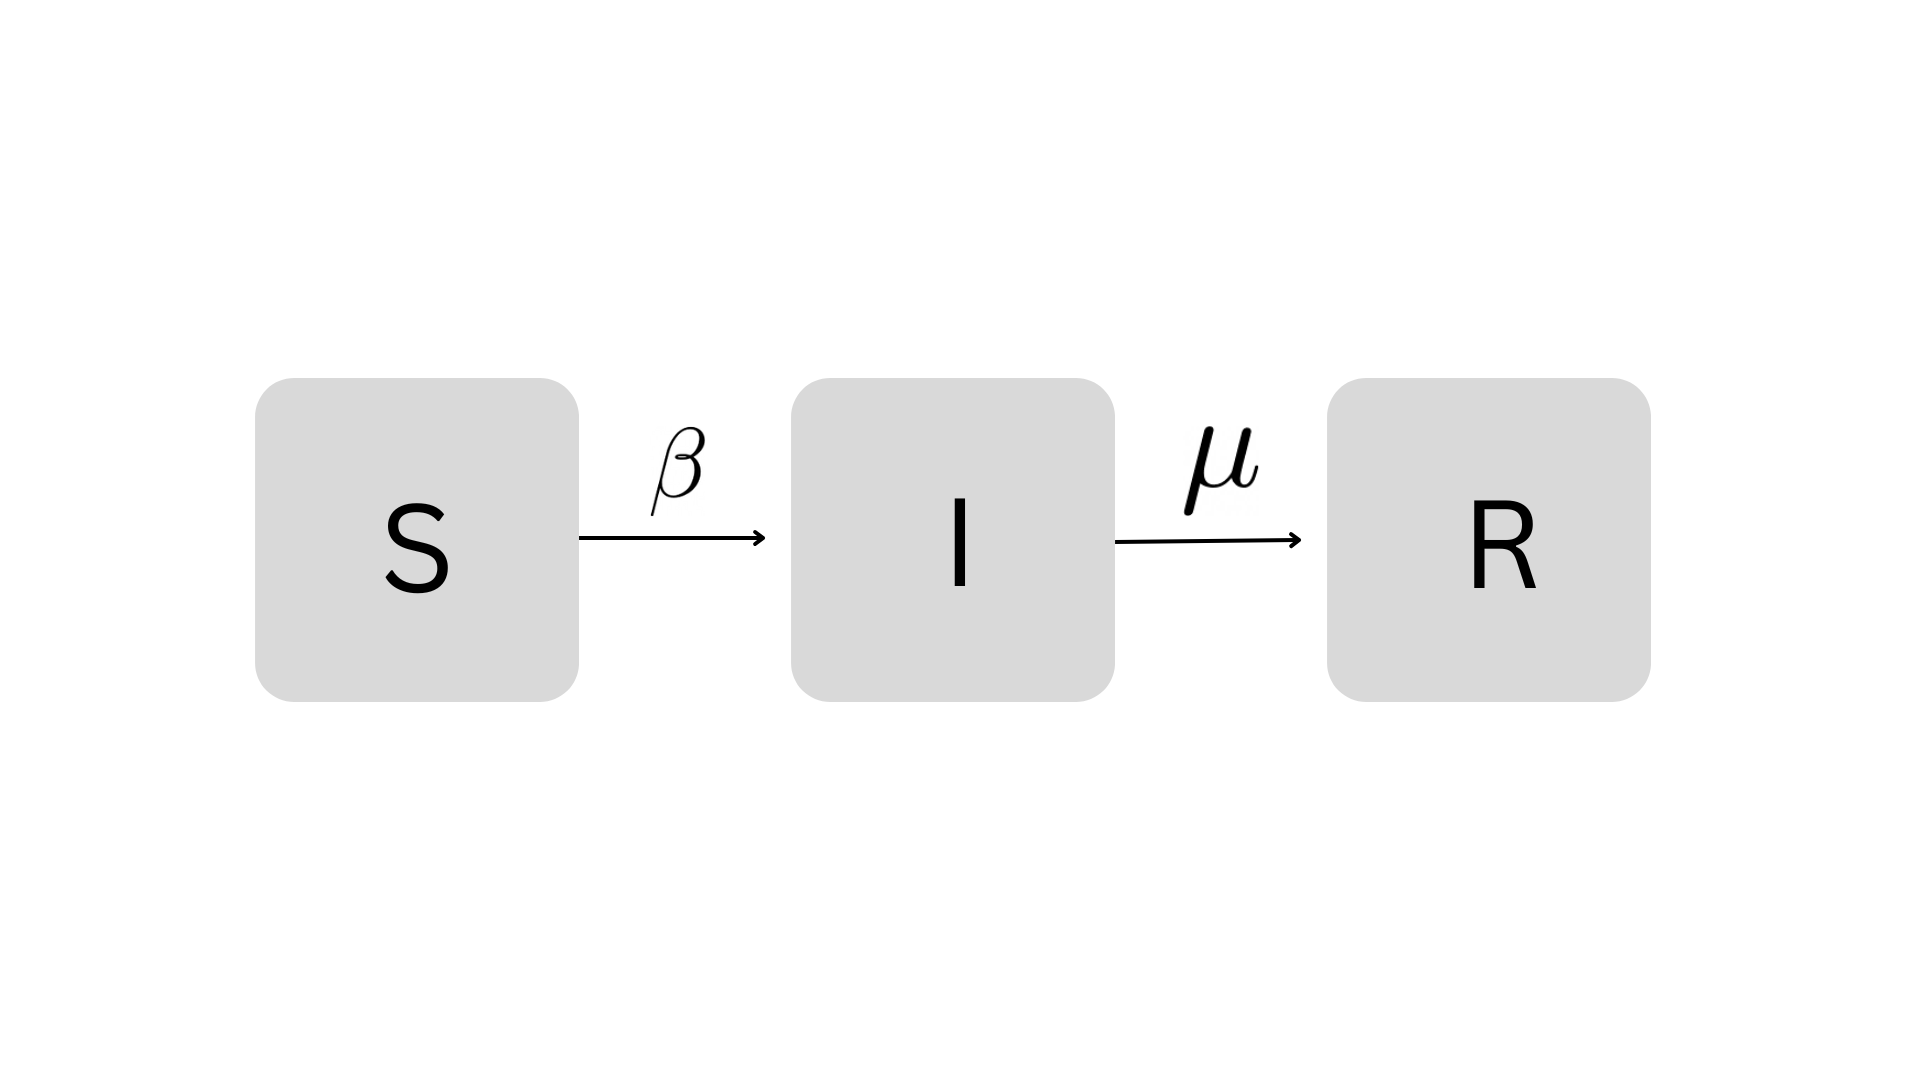
**Figura 1:** diagrama esquematizando o modelo SIR, em que $\beta$ corresponde a constante de infecção, e o $\mu$ a de recuperação.

$\quad$ Para entender o que está acontecendo nos termos das equações diferenciais, vamos pegar a equação (1) como exemplo. Nota-se que o único termo da expressão é composto pela multiplicação dos valores de $S$ e $I$ - que pode ser interpretado como o número de interações entre os indivíduos desses dois grupos. Nesse contexto, a constante $\beta$ age como um filtro, retornando a porcentagem das interações que resultaram em infecção. E como estamos tratando de $dS/dt$, o sinal negativo do termo é essencial por dizer que está diminuindo o número dos indivíduos infectados do grupo dos suscetíveis.

$\quad$ Tendo isso em vista, podemos definir as condições iniciais e constantes para as equações definidas na cédula anterior. Usando a função `odeint` da biblioteca `scipy`, encontramos as soluções numéricas para o nosso sistema, armazenando-os.

In [65]:
# Definimos os parametros e condições iniciais

beta = 0.4                   # Constante de infecção
mu = 0.1                     # Constante de recuperação 
y0 = [0.99,0.01, 0]          # Condições iniciais normalizadas
t = np.linspace(0, 100, 100) # Intervalo de tempo


# Resolvemos o sistema de equações diferenciais usando a função odeint
sol_SIR = odeint(dydt_SIR, y0, t, args=(beta, mu))

Com as soluções em mãos, podemos plotar as três curvas e ver o comportamento da epidemia com os valores escolhidos para as condições iniciais e constantes. Nessa figura é possível ver três fases da epidemia: o início em que a doença não alcançou tantas pessoas; um breve pico ao redor de 20 dias, indicando o momento em que a epidemia está no seu ponto mais crítico - com o maior número de infectados; e o final, em que a população de infectados se recuperou tornando-se imunes.

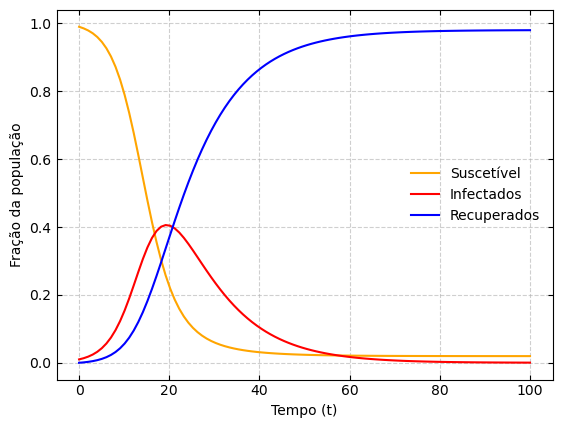

In [66]:
plt.plot(t, sol_SIR[:, 0], 'orange', label='Suscetível')
plt.plot(t, sol_SIR[:, 1], 'red', label='Infectados')
plt.plot(t, sol_SIR[:, 2], "blue", label="Recuperados")
plt.xlabel("Tempo")
plt.ylabel("Fração da população")
format()

$\quad$ Algo interessante de se notar é que o número de suscetíveis nunca chega a zero. Após o marco do 40° dia o valor de indivíduos suscetíveis se torna constante. Calculando na célula abaixo, vemos que essa parcela da população corresponde a quase 2 % da população que passou pela onda da epidemia, mas não foi afetado. Isso é o efeito da chamada imunidade de rebanho. Neste ponto, a maior parte da população está imunizada, dificultando a propagação do agente causador da doença para os indivíduos suscetíveis. Sem ter como se propagar, a epidemia vai morrendo aos poucos deixando esses 2 % livres.

In [67]:
parcela_sus = sol_SIR[-1,0]
print(f'Parcela da população que permanece suscetível após a evolução da doença = {100*parcela_sus:.2f} %')

Parcela da população que permanece suscetível após a evolução da doença = 1.96 %


$\quad$ Um adendo que se faz possível neste trabalho é falar das vacinas. Podemos adapatar as condições iniciais desse código de forma que 20 % da população esteja imunizada - aqui supomos pela vacinação em massa - e mantemos o número de infectados e as constantes as mesmas. Torna-se claro o efeito benéfico da imunização para lidar com a doença. No gráfico vemos que o número de infectado cai quase pela metade, e quando calculamos o número de suscetíveis no final do processo o número sobe de 1.96 % para 3.75 %.

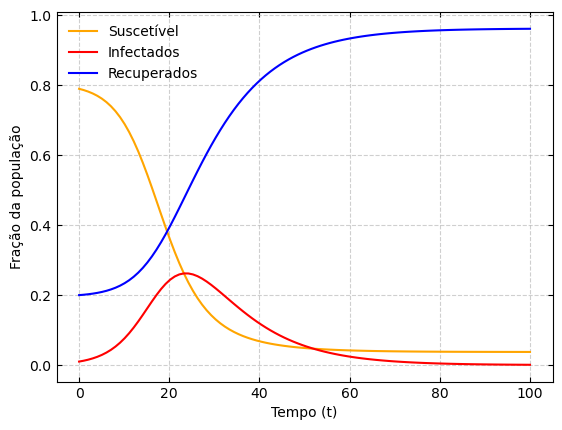

In [68]:
y0_vac = [0.79,0.01, 0.20]          # suscetíveis - infectados - imunes (e recuperados)

sol_SIR_vac = odeint(dydt_SIR, y0_vac, t, args=(beta, mu))

plt.plot(t, sol_SIR_vac[:, 0], 'orange', label='Suscetível')
plt.plot(t, sol_SIR_vac[:, 1], 'red', label='Infectados')
plt.plot(t, sol_SIR_vac[:, 2], "blue", label="Recuperados")
plt.xlabel("Tempo")
plt.ylabel("Fração da população")
format()

In [81]:
parcela_vac = sol_SIR_vac[-1,0]
print(f'Parcela da população que permanece suscetível havendo imunização em massa = {100*parcela_vac:.2f} %')

Parcela da população que permanece suscetível havendo imunização em massa = 3.75 %


$\quad$ Ou seja, pela mesma lógica da imunidade de rebanho, a imunização em massa — geralmente alcançada pela vacinação — funciona. A vacinação é um processo de profilaxia importante que ajuda a conter doenças, impedindo que parte da população contraia a moléstia e diminuindo seu impacto no organismo, reduzindo fatalidades. Portanto, vacinem-se!

Agora voltando a programação normal... :)

## 3. Abordagem estocástica

$\quad$ Epidemias raramente evoluem de forma previsível, como propõem os modelos determinísticos. Elementos de natureza aleatória — como quem será infectado, quando ou como — desempenham um papel crucial na evolução da epidemia. Por isso, exploramos os modelos estocásticos, que incorporam a incerteza no processo de propagação da doença, resultando em simulações mais realistas. Enquanto os modelos determinísticos descrevem o comportamento médio da população, os modelos estocásticos permitem que o fluxo de indivíduos entre os compartimentos varie de acordo com o acaso. Assim, o modelo estocástico fornece um intervalo de valores possíveis, o que se torna mais útil para a tomada de decisões, pois oferece uma visão mais abrangente, algo que um único valor do modelo determinístico não é capaz de fazer.

### 3.1 Algoritmo de Gillespie

$\quad$ Modelos estocásticos tornam-se importantes quando a aleatoriedade exerce um papel fundamental na evolução do sistema, considerando as flutuações estatísticas em sua dinâmica. Neste contexto, utilizaremos um modelo de tempo contínuo, no qual o tamanho do 'passo' de tempo ($\delta t$) é determinado aleatoriamente. Embora seja um modelo compartimental, em que os estados dos indivíduos (suscetível, infectado e recuperado) são discretos, esse método pode ser considerado uma implementação estocástica das equações diferenciais. [4] 

$\quad$ Para a implementação deste método, utilizamos o algoritmo de Gillespie. [5] Em 1977, esse algoritmo foi inicialmente pensado para descrever sistemas de reações químicas com poucas moléculas, em que flutuações aleatórias adotavam uma posição significativa. Como os modelos determinísticos falhavam em descrever sistemas dessa natureza, Gillespie propôs um modelo que incorporava flutuações aleatórias na forma de acréscimos de um $\delta t$ no passo de tempo de acordo com a probabilidade de reação acontecer. Por mais que tenha sido originalmente pensado para processos químicos, hoje o algoritmo é amplamente utilizado na biologia, em dinâmicas populacionais e na própria epidemologia, como exploramos neste trabalho. O algoritmo de Gillespie se tornou uma ferramenta fundamental para simular processos modelados como estocásticos e compartimentais, permitindo-nos construir modelos mais próximos da realidade. 

Uma abordagem matemática foge do escopo desse trabalho, mas pode ser encontrada no artigo original de Gillespie [5]. Assim, definimos a função `gillespie_algorithm`:

In [70]:
def gillespie_algorithm(reactions, initial_state, total_population, t_max):

    # Primeiramente, convertemos os estados iniciais de porcentagem para números inteiros; 
    state = (np.array(initial_state) * total_population).astype(int)
   
    # Iniciamos o tempo e armazenamos o mesmo e os estados normalizados.  
    t = 0            
    times = [t]
    states = [state.copy() / total_population] 
    
    # Loop principal. Vai repetir até t alcanças t_max. 
    while t < t_max:
        
        # Calcula a probabildade das reações acontecerem, sabendo o estado atual e as soma
        rates = np.array([reaction[0](*state) for reaction in reactions])
        total_rate = np.sum(rates)
        
        # Se não ocorrer reação, total_rate = 0 e a simulação para
        if total_rate == 0:
            break
        
        # Usando a função random, escolhemos o tempo "aleatório" até o próximo evento 
        # de uma distribuição exponencial
        
        dt = np.random.exponential(1 / total_rate)
        t += dt      # Soma no tempo anterior
        
        
        # Escolhe a equação que vai acontecer e atualiza o estado do sistema
        chosen_reaction = np.random.choice(len(reactions), p=rates / total_rate)
        state += reactions[chosen_reaction][1]
        
        # Guarda o novo tempo e estado 
        times.append(t)
        states.append(state.copy() / total_population)  # Estado normalizado
        
    return times, np.array(states)


$\quad$ A distribuição exponencial vem da definição de função de densidade de probabilidade que buscava responder quando a próxima reação, ou no nosso caso interação, iria acontecer. Com isso, Gillespie define uma função $P(\tau, \mu)$, em que $\tau$ representa um intervalo de tempo e o $\mu$ o tipo de reação. Vamos considerar $P(\tau, \mu) d\tau$ como sendo a probabilidade, dado um estado em um tempo $t$, que a próxima reação vai acontecer em um intervalo infinitesimal de tempo $d\tau$, e será uma reação do tipo $R_\mu$. Essa é a chamada "função de densidade da probabilidade de reação" no contexto de cinemática química, que podemos escrever como:

$$P(\tau, \mu) d\tau = P_0(\tau) \cdot a_\mu d\tau,$$

que é o produto entre a probabilidade de nenhuma reação acontecer ($P_0$) no intervalo de tempo $[t, t + dt]$ vezes a probabilidade subsequente de uma reação $R_\mu$ acontecer em um intervalo $[t + \tau, t + \tau + d\tau]$. Notando que $[1 - \sum a_\nu d\tau']$ é a probabilidade que nenhuma reação acontecerá, pode-se deduzir — após algum trabalho matemático — que a função probabilidade é dada por:

$$P(\tau, \mu) = a_\mu e^{-a_0\tau},$$

se $ 0 \le \tau < \infty $, e $P(\tau, \mu) = 0 $ caso contrário.


$\quad$ Pela forma que a função `gillespie_algorithm` foi construída, as equações só precisam levar me conta o fluxo que entra em cada compartimento. Já que há uma etapa que atualiza os estados do sistema, de forma que definimos 2 funções: uma para a taxa de infeção (sem o termo $-\mu I$) e outra para a de recuperação. 

In [73]:
def taxa_infeccao(S, I, R):
    return beta_norm * S * I 

def taxa_recuperacao(S, I, R):
    return mu * I

$\quad$ Agora podemos definir os parâmetros da simulação, em que usaremos as mesmas condições iniciais do modelo determinístico. Para definir as transições, -1 significa que está saindo daquele estado, 1 que está entrando, e 0 que não está sendo afetado.

In [ ]:
total_population = 1000  # Total population
beta_norm = beta/total_population  # Normaliza com a população para ficar na mesma escala do determinístico
t_max = 100 

# Define as reações com as transições entre os grupos.
reactions = [
    (infection_rate, np.array([-1, 1, 0])),  # Suscetível -> Infectado
    (recovery_rate, np.array([0, -1, 1]))   # Infectado -> Recuperado
]

$\quad$ Dessa forma, podemos rodar a simulação e plotar o resultado do modelo estocástico. Nota-se que as curvas não são suaves como o do modelo determinístico, possuindo a oscilação esperada como consequência de um processo estocástico. Porém, também é notório que a forma das curvas ainda obedece o mesmo comportamento que o modelo determinístico — claro, já que são as mesmas equações que fundamental ambos. Mas apesar das flutuações aleatórias, a o comportamento geral permaneca.

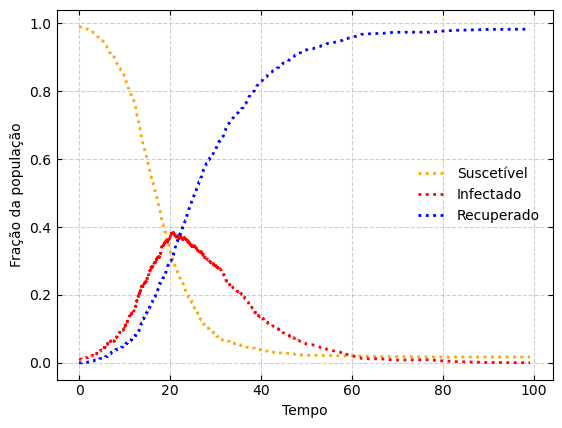

In [75]:
times, states = gillespie_algorithm(reactions, y0, total_population, t_max)


plt.plot(times, states[:, 0], label='Suscetível', color='orange', ls = ':',linewidth=2)
plt.plot(times, states[:, 1], label='Infectado', color='red', ls = ':', linewidth=2)
plt.plot(times, states[:, 2], label='Recuperado', color='blue',ls = ':', linewidth=2)
plt.xlabel("Tempo")
plt.ylabel("Fração da população")
format()
plt.show()


## 4. Comparação

$\quad$ Uma vez estabelecidos os dois modelos, podemos comparar o comportamento de ambos, plotando-os em um mesmo gráfico. Para isso, comparamos 10 simulações do modelo estocástico, implementado com o algoritmo de Gillespie, à solução obtida pelo modelo determinístico. Assim, conseguimos visualizar os conceitos discutidos nas seções anteriores. As linhas sólidas correspondem ao modelo determinístico, enquanto as linhas pontilhadas representam o modelo estocástico. Visualmente, fica evidente que o modelo determinístico atua como uma média do comportamento apresentado pelo modelo estocástico.

$\quad$ Um questionamento natural seria: qual modelo é o melhor? A resposta é: depende. Modelos determinísticos assumem que a população é grande o suficiente para que flutuações aleatórias possam ser desprezadas. Eles produzem curvas suaves, onde o comportamento médio do processo prevalece — sendo úteis para o estudo de grandes populações ou para compreender a dinâmica geral de uma epidemia. São computacionalmente eficientes e servem como uma primeira abordagem em análises teóricas e práticas.

$\quad$ Por outro lado, modelos estocásticos — como o baseado no algoritmo de Gillespie, utilizado aqui — descrevem melhor situações em menor escala, nas quais a aleatoriedade do processo se torna significativa. Cenários como pequenas comunidades, o início de um surto, ou situações com poucos indivíduos infectados se encaixam nesse perfil. Esses modelos conseguem representar a variabilidade do sistema, sendo úteis para decisões rápidas ao oferecer uma noção dos diferentes desfechos possíveis — algo que os modelos determinísticos falham. No entanto, a análise matemática de processos estocásticos é mais complexa e geralmente depende de métodos numéricos.

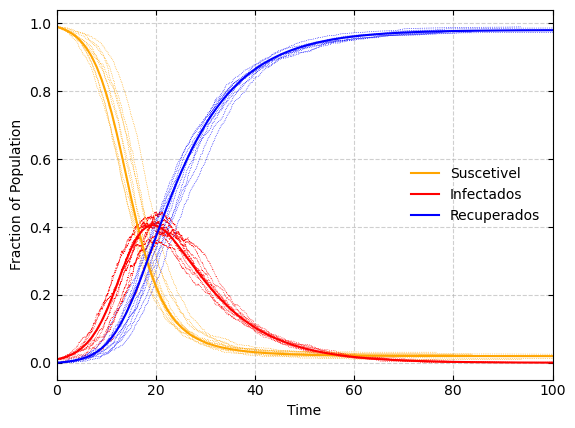

In [79]:
for i in range(0,10):
    times, states = gillespie_algorithm(reactions, y0, total_population, t_max)

    plt.plot(times, states[:, 0], color='orange', ls = ':',linewidth=0.5)
    plt.plot(times, states[:, 1], color='red', ls = ':', linewidth=0.5)
    plt.plot(times, states[:, 2], color='blue',ls = ':', linewidth=0.5)

plt.plot(t, sol_SIR[:, 0], 'orange', label='Suscetível')
plt.plot(t, sol_SIR[:, 1], 'red', label='Infectado')
plt.plot(t, sol_SIR[:, 2], "blue", label="Recuperado")
plt.xlabel('Time')
plt.ylabel('Fraction of Population')
plt.xlim(0,100)
format()
plt.show()


## 5. Conclusão

$\quad$ A modelagem de doenças infecciosas exige um equilibrio entre aplicabilidade, realismo e simplicidade. Neste `Notebook`, buscamos comparar os modelos determinísticos e estocásticos. Os modelos determinísticos, baseados em equações diferenciais, descrevem uma visão clara e simples do comportamento de uma epidemia - condizendo com aplicação a grandes populações, ou análises preliminares. Contudo, a natureza aleaória presente na evolução da propagação de doenças não pode ser negligenciada. 

$\quad$ Nesse contexto, modelos estocásticos se tornam importantes. Ao incluir flutuações de natureza aleatória, os modelos produzem resultados que se aproximam mais do comportamento observado na realidade com variações nos processos e transmissões — que os modelos determinísticos não englobam. O algoritmo de Gillespie é uma ferramenta poderosa para a simulação desse tipo de processos na epidemologia, modelando-os como uma sequência de eventos probabilísticos em tempo contínuo.


$\quad$ Pudemos ver que os modelos apresentam as mesmas fases de uma epidemia, como também o impacto de uma imunização em massa no caso determinístico. Dessa maneira, concluímos que cada modelo atende a contextos específicos. De acordo com o tamanho da população e o estágio da epidemia, o determinístico pode ajudar a enxergar a dinâmica geral da evolução da doença, enquanto o estocástico apresenta os extremos que flutuações aleatórias podem levar a epidemia. 

## 6. Bônus: visualização da propagação de doença

$\quad$ Esta última seção tem como o objetivo a explicação de um código que gera um gif no qual é possível visualizar como as doenças se propagam em duas dimensões. A ideia da animação é bem simples, montamos uma grade e colocamos um número inicial de pessoas infectadas. Com isso, vamos percorrendo o grid e ao encontrar um indivíduo suscetível e checamos seus vizinhos, se ouver um infectado calculamos a chance de ter se infectado. Caso o indivíduo suscetível tenha se infectado, mudamos seu estado. Após o número de passos para a recuperação, aqui definido como $1/\mu$, quem estava infectado passa para o estado de recuperado. Assim a simulação se repete até alcançar o número de frames estabelecidos. 

$\quad$ Podemos inicializar as constantes (para evitar problemas com variáveis de mesmo nome) e os estados, como também definir a grade.


In [ ]:
# Tamanho da grade
N = 200
infection_rate = beta  # Probabilidade de infecção por um vizinho
recovery_time = 1/mu    # Passos de tempo para a recuperação

# Estados
SUSCEPTIBLE = 0  # Azul
INFECTED = 1     # Vermelho
RECOVERED = 3    # Amarelo

# Iniciando a grade
grid = np.zeros((N, N), dtype=int)

$\quad$ Introduzimos um número de indivíduos infectados em pontos aleatórios da grade, e definimos um temporizador para marcar o tempo de infecção para cada célula (indivíduo) da célula.

In [ ]:
num_initial_infected = 15
for _ in range(num_initial_infected):
    x, y = np.random.randint(0, N, 2)
    grid[x, y] = INFECTED
    

infection_timer = np.zeros((N, N), dtype=int)

$\quad$ Assim, montamos a função `update` para percorrer a grade e atualizar os estados de cada indivíduo de acordo com suas interações e probabilidade de terem sido infectados.

In [ ]:
def update(frame):
    global grid, infection_timer
    new_grid = grid.copy()
    
    for x in range(N):
        for y in range(N):
            if grid[x, y] == SUSCEPTIBLE:  # Se susceptível, checa os vizinhos
                neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
                neighbors = [(i, j) for i, j in neighbors if 0 <= i < N and 0 <= j < N]
                if any(grid[i, j] == INFECTED for i, j in neighbors):
                    if np.random.rand() < infection_rate:
                        new_grid[x, y] = INFECTED  # Ocorre a infecção
            
            elif grid[x, y] == INFECTED:  # Se infectado, atualiza o temporizador
                infection_timer[x, y] += 1
                if infection_timer[x, y] >= recovery_time:
                    new_grid[x, y] = RECOVERED  # Atualiza os recuperados

    grid[:] = new_grid  # Atualiza a grade

    # Atualiza visualização
    img.set_array(grid)
    return img,


$\quad$ Por fim, montamos a animação usando o pacote `animation` do `matplolib` para gerar o nosso gif que será salvo na máquina que o leitor estiver usando. Permitindo-nos visualizar em duas dimensões a rapidez com que uma epidemia do tipo que modelamos ao longo deste `Notebook` se propaga.

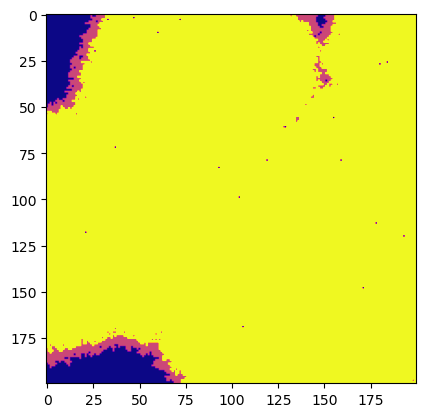

In [49]:
# Set up the figure for animation
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap="plasma", vmin=0, vmax=2)

# Create animation

ani = animation.FuncAnimation(fig, update, frames=100, interval=100, blit=False)
ani.save('sir_simulation.gif', writer='pillow', fps=10)

![SIR Model Simulation](sir_simulation.gif)

## Referências

**[1]** Capasso, V. (2008). Mathematical Structures of Epidemic Systems. Springer Science & Business Media.


**[2]** Hethcote H.W. (1989). Three Basic Epidemiological Models. Em: Levin, S.A., Hallam, T.G. and Gross, L.J. Applied Mathematical Ecology. Springer Science & Business Media, pp.120-144.

**[3]** Li, M.Y. (2019). Introduction To Mathematical Modeling Of Infectious Diseases. S.L.: Springer International Pu.


**[4]** Vynnycky, E., White, R.G. and Fine, P.E.M. (2011). An introduction to infectious disease modelling. Oxford Oxford University Press.


**[5]** Gillespie, D.T. (1977). Exact stochastic simulation of coupled chemical reactions. The Journal of Physical Chemistry, 81(25), pp.2340–2361. doi:https://doi.org/10.1021/j100540a008.

‌
